# Project 4: Probabilistic Modeling

## Naïve Bayes

We implement he Naïve Bayes classifier to perform text classification. 

### Load dataset


In [51]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def create_dataset():
    # Generate a dataset for classification
    X, y = make_classification(n_samples=1250, n_features=2, n_redundant=0, 
                               n_informative=2, random_state=1, 
                               n_clusters_per_class=1)
    
    # Add noise to make the dataset linearly inseparable
    rng = np.random.RandomState(2)
    X += 3 * rng.uniform(size=X.shape)
    
    # Scale the features
    X = StandardScaler().fit_transform(X)
    
    return X, y

# Generate the dataset
X, y = create_dataset()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
import numpy as np

def gaussian_pdf(x, mean, var):
    """Calculate the Gaussian probability density function."""
    eps = 1e-4  # to prevent division by zero
    coeff = 1.0 / np.sqrt(2.0 * np.pi * var + eps)
    exponent = np.exp(-(np.power(x - mean, 2) / (2 * var + eps)))
    return coeff * exponent

def evaluate_accuracy(y_true, y_pred):
    """
    Calculates the accuracy of predictions.
    
    Parameters:
    - y_true: Array of true labels
    - y_pred: Array of predicted labels
    
    Returns:
    - Accuracy: The proportion of correctly predicted labels
    """
    correct_predictions = np.sum(y_true == y_pred)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return accuracy

### Calculate Prior Probabilities

Prior class probabilities $P_{\theta}(y=c)$

In [53]:
# Function to calculate the prior probabilities of each class
def calculate_class_priors(y_train):
    """
    Calculates the prior probabilities P(Y) for each class in the training set.

    For example, if we have a vector y_train = [0, 1, 0, 0, 1, 0]
    composed of two classes 0 and 1, the prior probabilities of each class
    that you would return are:
    {
        0: 0.666,
        1: 0.333,
    }
    
    Parameters:
    - y_train: Array of training labels
    
    Returns:
    - Dictionary of prior probabilities for each class
    """
    priors = {}
    keys = list(set(y_train))
    for key in keys:
        count = 0
        for i in range(len(y_train)):
            if y_train[i] == key:
                count += 1
        priors[key] = count/len(y_train)
    return priors

### Calculate class-conditional density parameters

We calculate the parameters of the class-conditional data density \(P(X|Y)\) of observing each feature given each class. 

In [54]:
# Function to calculate the parameters for the class-conditional Gaussian
# density of each feature
def calculate_gaussian_density_params(features, labels):
    """
    Calculates the likelihood P(X|Y) for each feature given a class.

    For example, if we had one feature X_1 and a target Y \in {0, 1},
    we would return:
    {
        0: [(mean(X_1 | Y=0), var(X_1 | Y=0))],
        1: [(mean(X_1 | Y=1), var(X_1 | Y=1))],
    }
    
    Parameters:
    - features: Array of features in the training set
    - labels: Array of labels corresponding to the features
    
    Returns:
    - Dictionary of Gaussian density parameters for each feature given each class
    """
    likelihood = {}
    classes = list(set(labels))

    for label in classes:
      label_idxs = np.where(labels == label)[0]
      label_features = features[label_idxs]
      class_likelihood = [(np.mean(label_features[:,i]), np.var(label_features[:, i])) for i in range(label_features.shape[1])]
      likelihood[label] = class_likelihood
    return likelihood

### Implement the Classifier

We use priors and likelihoods calculated in the previous tasks to classify each sample in the test set. Then, we apply Bayes' theorem to compute the posterior probability for each class given the sample and predict the class with the highest posterior probability.

In [55]:
# Naive Bayes classifier function
def naive_bayes_classifier(X_train, y_train, X_test):
    """
    Classifies each sample in the test set based on the Naive Bayes algorithm.

    Steps:
    - Compute class prior probabilities using the training set labels.
    - Compute class-conditional density parameters from training data.
    - For each sample x in the test set:
        - Use the density params (mu_i, var_i) learned from training data to compute
          the log-likelihood of observing feature x_i.
        - Apply Bayes theorem to compute posterior class probabilities P(y|x)
          from the feature log-likelihood and prior log-likelihood.
          You will use log-likelihood here to avoid underflow.
    
    Parameters:
    - X_train: Training set features
    - y_train: Training set labels
    - X_test: Test set features
    
    Returns:
    - Predicted classes for the test set
    """
    predictions = []

    priors = calculate_class_priors(y_train)
    params = calculate_gaussian_density_params(X_train, y_train)

    for x in X_test:
        max = -np.inf
        max_label = 0
        for label, prob in priors.items():
            likelihood = np.sum([np.log(gaussian_pdf(x[i], params[label][i][0], params[label][i][1])) for i in range(len(x))])
            posterior_prob = np.log(prob) + likelihood
            if posterior_prob > max:
                max = posterior_prob
                max_label = label
        predictions.append(max_label)
    return predictions

### Run the classifier

In [56]:
predictions = naive_bayes_classifier(X_train, y_train, X_test)

In [57]:
accuracy = evaluate_accuracy(predictions, y_test)
print(f"The test accuracy is {accuracy * 100}%.")

The test accuracy is 78.0%.


## Image Completion with Mixture of Bernoullis and EM 

#### Mixture of Bernoullis
Each image we'll deal with is 28-by-28, and each pixel takes values in $\{0, 1\}$. For simplicity, we ignore the spatial structure of the images, and flatten the image into a 784-dimensional binary vectors.

Each mixture of Bernoullis component consists of a collection of independent Bernoulli random variables. By denoting the image as $\mathbf{x} \in \mathbb{R}^{784}$, and the latent variable $z$. Then the conditional probability of an image $\mathbf{x} = \mathbf{x}^{(i)}$ given the label ${z}=k$ is
\begin{align}
    p(\mathbf{x}^{(i)}|{z}=k)&= \prod_{j=1}^{784} p(\mathbf{x}_{j}^{(i)}|z=k) \\
    & =  \prod_{j=1}^{784} \mathbf{\theta}_{k, j}^{\mathbf{x}_{j}^{(i)}} (1-\mathbf{\theta}_{k, j})^{1-\mathbf{x}_{j}^{(i)}}
\end{align}


In [58]:
import numpy as np
import pylab
import time

# import checking
import util

try:
    from scipy.special import gammaln
except:
    pass

IMAGE_DIM = 28

TRAIN_IMAGES_FILE = 'train-images-idx3-ubyte'
TRAIN_LABELS_FILE = 'train-labels-idx1-ubyte'
TEST_IMAGES_FILE = 't10k-images-idx3-ubyte'
TEST_LABELS_FILE = 't10k-labels-idx1-ubyte'


def beta_log_pdf(theta, a, b):
    """Log PDF of the beta distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a + b) - gammaln(a) - gammaln(b)
    return norm_const + (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)

def beta_log_pdf_unnorm(theta, a, b):
    """Unnormalized log PDF of the beta distribution."""
    return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)

def dirichlet_log_pdf(pi, a):
    """Log PDF of the Dirichlet distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a.sum()) - gammaln(a).sum()
    return norm_const + np.sum((a - 1.) * np.log(pi))

def dirichlet_log_pdf_unnorm(pi, a):
    """Unnormalized log PDF of the Dirichlet distribution."""
    return np.sum((a - 1.) * np.log(pi))


class Params(object):
    """A class which represents the trainable parameters of the mixture model.
        - pi: the mixing proportions, represented as a K-dimensional array. It must be a
            probability distribution, i.e. the entries must be nonnegative and sum to 1.
        - theta: The Bernoulli parameters for each pixel in each mixture component. This is
            a K x D matrix, where rows correspond to mixture components and columns correspond
            to pixels. """

    def __init__(self, pi, theta):
        self.pi = pi
        self.theta = theta

    @classmethod
    def random_initialization(cls, num_components, num_pixels):
        init_pi = np.ones(num_components) / num_components
        init_theta = np.random.uniform(0.49, 0.51, size=(num_components, num_pixels))
        return Params(init_pi, init_theta)

class Prior(object):
    """A class representing the priors over parameters in the mixture model.
        - a_mix: A scalar valued parameter for the Dirichlet prior over mixing proportions.
        - a_pixels and b_pixels: The scalar-valued parameters for the beta prior over the entries of
            theta. I.e., the entries of theta are assumed to be drawn i.i.d. from the distribution
            Beta(a_pixels, b_pixels). """

    def __init__(self, a_mix, a_pixels, b_pixels):
        self.a_mix = a_mix
        self.a_pixels = a_pixels
        self.b_pixels = b_pixels

    @classmethod
    def default_prior(cls):
        """Return a Prior instance which has reasonable values."""
        return cls(2., 2., 2.)

    @classmethod
    def uniform_prior(cls):
        """Return a set of prior parameters which corresponds to a uniform distribution. Then
        MAP estimation is equivalent to maximum likelihood."""
        return cls(1., 1., 1.)


def multinomial_entropy(p):
    """Compute the entropy of a Bernoulli random variable, in nats rather than bits."""
    p = np.clip(p, 1e-20, np.infty)      # avoid taking the log of 0
    return -np.sum(p * np.log(p))


def variational_objective(model, X, R, pi, theta):
    """Compute the variational lower bound on the log-likelihood that each step of E-M
    is maximizing. This is described in the paper

        Neal and Hinton, 1998. A view of the E-M algorithm that justifies incremental, sparse, and other variants.

    We can test the update rules by verifying that each step maximizes this bound.
    """

    model = Model(model.prior, Params(pi, theta))
    expected_log_prob = model.expected_joint_log_probability(X, R)
    entropy_term = np.sum(multinomial_entropy(R))
    return expected_log_prob + entropy_term

def perturb_pi(pi, eps=1e-6):
    pi = np.random.normal(pi, eps)
    pi = np.clip(pi, 1e-10, np.infty)
    pi /= pi.sum()
    return pi

def perturb_theta(theta, eps=1e-6):
    theta = np.random.normal(theta, eps)
    theta = np.clip(theta, 1e-10, 1. - 1e-10)
    return theta

def perturb_R(R, eps=1e-6):
    R = np.random.normal(R, eps)
    R = np.clip(R, 1e-10, np.infty)
    R /= R.sum(1).reshape((-1, 1))
    return R

def train_from_labels(prior=None, show=True):
    """Fit the mixture model using the labeled MNIST data. There are 10 mixture components,
    one corresponding to each of the digit classes."""

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    y = util.read_mnist_labels(TRAIN_LABELS_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    if prior is None:
        prior = Prior.default_prior()
    model = Model.random_initialization(prior, 10, IMAGE_DIM**2)

    R = np.zeros((num_data, 10))
    R[np.arange(num_data), y] = 1.
    model.params.pi = model.update_pi(R)
    model.params.theta = model.update_theta(X, R)

    # mask which includes top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1]//2] = 1

    if show:
        model.visualize_components()
        try:
            model.visualize_predictions(X[:64, :], M[:64, :])
        except:
            print('Posterior predictive distribution not implemented yet.')

        print('Training log-likelihood:', model.log_likelihood(X) / num_data)
        print('Test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])

    return model

### Parameter Learning via EM

In the first step, we’ll learn the parameters of the model given the responsibilities, using the Maximum A Posteriori (MAP) criterion. This corresponds to the M-step of the E-M (Expectation-Maximization) algorithm.


$$\sum_{i=1}^N \sum_{k=1}^K r^{(i)}_{k} \left[\log p(z^{(i)}=k) + \log p(x^{(i)}|z^{(i)}=k)\right]$$

Our prior for $\mathbf{\Theta}$ is as follows: every entry is drawn independently from a beta distribution with parameters a and b. The beta distribution is

$$p(\theta_{k,j})\propto \theta_{k,j}^{a-1}(1-\theta_{k,j})^{b-1}$$


For the prior over mixing proportions $\mathbf{\pi}$, we’ll use the Dirichlet distribution

$$p(\mathbf{\pi})\propto \pi_1^{a_1-1}\pi_2^{a_2-1}\ldots\pi_{K}^{a_K-1}$$


In [59]:
class Model(object):
    """A class implementing the mixture of Bernoullis model. The fields are:
        - prior: an Prior instance
        - params: a Params instance"""

    def __init__(self, prior, params):
        self.prior = prior
        self.params = params

    @classmethod
    def random_initialization(cls, prior, num_components, num_pixels):
        params = Params.random_initialization(num_components, num_pixels)
        return cls(prior, params)

    def expected_joint_log_probability(self, X, R):
        """Compute the expected joint log probability, where the expectation is with respect to
        the responsibilities R. This is the objective function being maximized in the M-step.
        It's useful for verifying the optimality conditions in the M-step."""

        total = 0.

        # Prior over mixing proportions
        total += dirichlet_log_pdf_unnorm(self.params.pi, self.prior.a_mix)

        # Prior over pixel probabilities
        total += np.sum(beta_log_pdf_unnorm(self.params.theta, self.prior.a_pixels, self.prior.b_pixels))

        # Probability of assignments
        total += np.sum(R * np.log(self.params.pi))

        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)

        # Observation probabilities
        total += np.sum(R * log_p_x_given_z)

        return total

    def log_likelihood(self, X):
        """Compute the log-likelihood of the observed data, i.e. the log probability with the
        latent variables marginalized out."""

        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)
        log_p_z_x = log_p_x_given_z + np.log(self.params.pi)

        # This is a numerically stable way to compute np.log(np.sum(np.exp(log_p_z_x), axis=1))
        log_p_x = np.logaddexp.reduce(log_p_z_x, axis=1)

        return log_p_x.sum()

    def update_pi(self, R):
        """Compute the update for the mixing proportions in the M-step of the E-M algorithm.
        You should derive the optimal value of pi (the one which maximizes the expected log
        probability) by setting the partial derivatives of the Lagrangian to zero. You should
        implement this in terms of NumPy matrix and vector operations, rather than a for loop."""

        numer = self.prior.a_mix - 1 + np.sum(R, axis=0)
        denom = R.shape[0] + R.shape[1]*np.sum(self.prior.a_mix - 1)
        self.params.pi = numer / denom
        return self.params.pi

    def update_theta(self, X, R):
        """Compute the update for the Bernoulli parameters in the M-step of the E-M algorithm.
        You should derive the optimal value of theta (the one which maximizes the expected log
        probability) by setting the partial derivatives to zero. You should implement this in
        terms of NumPy matrix and vector operations, rather than a for loop."""

        numer = np.dot(R.T, X) + self.prior.a_pixels - 1
        denom = np.sum(R, axis=0).reshape(-1, 1) + self.prior.a_pixels + self.prior.b_pixels - 2
        self.params.theta = numer / denom
        return self.params.theta

    def compute_posterior(self, X, M=None):
        """Compute the posterior probabilities of the cluster assignments given the observations.
        This is used to compute the E-step of the E-M algorithm. It's also used in computing the
        posterior predictive distribution when making inferences about the hidden part of the image.
        It takes an optional parameter M, which is a binary matrix the same size as X, and determines
        which pixels are observed. (1 means observed, and 0 means unobserved.)
        Your job is to compute the variable log_p_z_x, which is a matrix whose (i, k) entry is the
        log of the joint proability, i.e.
             log p(z^(i) = k, x^(i)) = log p(z^(i) = k) + log p(x^(i) | z^(i) = k)
        Hint: the solution is a small modification of the computation of log_p_z_x in
        Model.log_likelihood.
        """

        if M is None:
            M = np.ones(X.shape, dtype=int)

        log_p_x_given_z = np.dot(M * X, np.log(self.params.theta).T) + \
                          np.dot(M * (1. - X), np.log(1. - self.params.theta).T)
        log_p_z_x = log_p_x_given_z + np.log(self.params.pi)     

        # subtract the max of each row to avoid numerical instability
        log_p_z_x_shifted = log_p_z_x - log_p_z_x.max(1).reshape((-1, 1))

        # convert the log probabilities to probabilities and renormalize
        R = np.exp(log_p_z_x_shifted)
        R /= R.sum(1).reshape((-1, 1))
        return R

    def posterior_predictive_means(self, X, M):
        """Compute the matrix of posterior predictive means for unobserved pixels given the observed
        pixels. The matrix M is a binary matrix the same size as X which determines which pixels
        are observed. (1 means observed, and 0 means unobserved.) You should return a real-valued
        matrix the same size as X. For all the entries corresponding to unobserved pixels, the value
        should determine the posterior probability that the pixel is on, conditioned on the observed
        pixels. It does not matter what values you assign for observed pixels, since those values
        aren't used for anything. """
        return np.dot(self.compute_posterior(X, M), self.params.theta)

    def visualize_components(self, title=None):
        """Visualize the learned components. Each of the images shows the Bernoulli parameters
        (probability of the pixel being 1) for one of the mixture components."""

        pylab.figure('Mixture components')
        pylab.matshow(util.arrange(self.params.theta.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Mixture components'
        pylab.title(title)
        pylab.draw()

    def visualize_predictions(self, X, M, title=None):
        """Visualize the predicted probabilities for each of the missing pixels."""

        P = self.posterior_predictive_means(X, M)
        imgs = np.where(M, X, P)
        obs = np.where(M, X, 0.3)

        pylab.figure('Observations')
        pylab.matshow(util.arrange(obs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        pylab.title('Observations')

        pylab.figure('Model predictions')
        pylab.matshow(util.arrange(imgs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Model predictions'
        pylab.title(title)
        pylab.draw()


In [60]:
def check_m_step():
    """Check that the M-step updates by making sure they maximize the variational
    objective with respect to the model parameters."""
    np.random.seed(0)

    NUM_IMAGES = 100

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X = X[:NUM_IMAGES, :]
    R = np.random.uniform(size=(NUM_IMAGES, 10))
    R /= R.sum(1).reshape((-1, 1))
    model = Model.random_initialization(Prior.default_prior(), 10, 784)

    theta = model.update_theta(X, R)
    pi = model.update_pi(R)



    opt = variational_objective(model, X, R, pi, theta)

    ok = True
    for i in range(20):
        new_theta = perturb_theta(theta)
        new_obj = variational_objective(model, X, R, pi, new_theta)
        if new_obj > opt:
            ok = False
    if ok:
        print('The theta update seems OK.')
    else:
        print('Something seems to be wrong with the theta update.')

    if not np.allclose(np.sum(pi), 1.):
        print('Uh-oh. pi does not seem to sum to 1.')
    else:
        ok = True
        for i in range(20):
            new_pi = perturb_pi(pi)
            new_obj = variational_objective(model, X, R, new_pi, theta)
            if new_obj > opt:
                ok = False
        if ok:
            print('The pi update seems OK.')
        else:
            print('Something seems to be wrong with the pi update.')

In [61]:
check_m_step()

The theta update seems OK.
The pi update seems OK.


### Posterior inference
Now we derive the posterior probability distribution $p(z|\mathbf{x}_{\text{obs}})$, where $\mathbf{x}_{\text{obs}}$ denotes the subset of the
pixels which are observed. In the implementation, we will represent partial observations in terms
of variables $m^{(i)}_j$, where $m^{(i)}_j=1$ if the $j$th pixel of the $i$th image is observed, and $0$ otherwise. In the implementation, we organize the $m_j^{(i)}$'s into a matrix $\mathbf{M}$ which is the same shape as $\mathbf{X}$.

In [62]:
def check_e_step():
    """Check the E-step updates by making sure they maximize the variational
    objective with respect to the responsibilities. Note that this does not
    fully check your solution to Part 2, since it only applies to fully observed
    images."""

    np.random.seed(0)

    NUM_IMAGES = 100

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X = X[:NUM_IMAGES, :]
    model = train_from_labels(show=False)

    # reduce the number of observations so that the posterior is less peaked
    X = X[:, ::50]
    model.params.theta = model.params.theta[:, ::50]

    R = model.compute_posterior(X)

    opt = variational_objective(model, X, R, model.params.pi, model.params.theta)

    if not np.allclose(R.sum(1), 1.):
        print('Uh-oh. Rows of R do not seem to sum to 1.')
    else:
        ok = True
        for i in range(20):
            new_R = perturb_R(R)
            new_obj = variational_objective(model, X, new_R, model.params.pi, model.params.theta)
            if new_obj > opt:
                ok = False
        if ok:
            print('The E-step seems OK.')
        else:
            print('Something seems to be wrong with the E-step.')

In [63]:
check_e_step()

The E-step seems OK.


### Results

In [64]:
def train_with_em(num_components=100, num_steps=50, prior=None, draw_every=1):
    """Fit the mixture model in an unsupervised fashion using E-M."""

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    if prior is None:
        prior = Prior.default_prior()
    model = Model.random_initialization(prior, num_components, num_pixels)

    # mask which includes top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1]//2] = 1

    loglik_vals = []

    for i in range(num_steps):
        # E-step
        R = model.compute_posterior(X)

        # M-step
        model.params.pi = model.update_pi(R)
        model.params.theta = model.update_theta(X, R)

        loglik = model.log_likelihood(X) / num_data
        loglik_vals.append(loglik)

        if (i+1) % draw_every == 0:
            model.visualize_components()
            model.visualize_predictions(X[:64, :], M[:64, :])

            pylab.figure('Log-likelihood')
            pylab.clf()
            pylab.semilogx(np.arange(1, i+2), loglik_vals)
            pylab.title('Log-likelihood')
            pylab.xlabel('Number of E-M steps')
            pylab.draw()

    print('Final training log-likelihood:', model.log_likelihood(X) / num_data)
    print('Final test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])

    return model

Final training log-likelihood: -137.78889260387896
Final test log-likelihood: -138.26583341994768


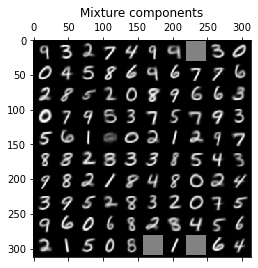

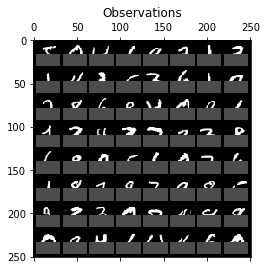

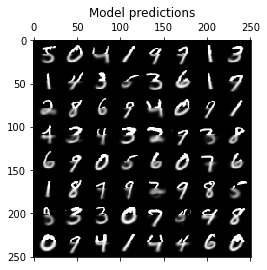

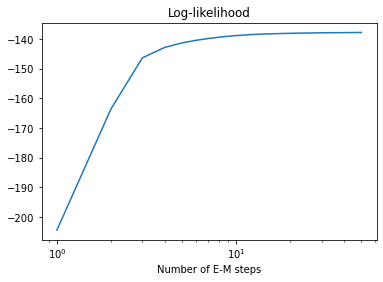

In [65]:
model = train_with_em(num_components=100, num_steps=50)

###  Anomaly detection



[ -95.13035036 -189.9474035   -54.61794012 ... -152.83895313 -152.18347605
  172.27963143]


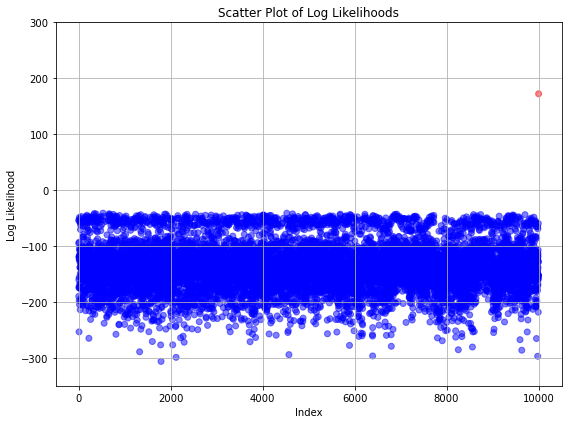

In [104]:
import matplotlib.pyplot as plt

X_test = util.read_mnist_images(TEST_IMAGES_FILE)
outlier = np.random.randn(1, 784)
X_test = np.vstack([X_test, outlier])

test_likelihoods = np.array([model.log_likelihood(x.reshape(1, -1)) for x in X_test]) 
print(test_likelihoods)

"""Create scatter plot with log-likelihoods of test data, with x-axis as index and 
y-axis as log-likelihood given the model""" 
plt.figure(figsize=(8, 6))
plt.scatter(np.arange(len(test_likelihoods)), test_likelihoods, color=np.where(test_likelihoods<0, 'blue', 'red'), marker='o', alpha=0.5)
# Add labels and title
plt.xlabel('Index')
plt.ylabel('Log Likelihood')
plt.ylim(-350, 300)
plt.title('Scatter Plot of Log Likelihoods')

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()
